In [1]:
import io
import h5py
import argparse
import torch
import time
import pickle
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image                       
from torch import nn
from datetime import timedelta
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from sklearn.neighbors import NearestNeighbors

In [2]:
from pathlib import Path
import tqdm
import cv2
import nltk
!pip install --upgrade keras -q
import keras
import torch
import pandas as pd
!pip install --upgrade diffusers transformers -q
import matplotlib.pyplot as plt

2024-06-20 10:01:10.209172: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-20 10:01:10.209289: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-20 10:01:10.338925: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [3]:
from diffusers import StableDiffusionPipeline
import matplotlib.pyplot as plt
import torch

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/opt/conda/lib/python3.10/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


In [4]:
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

In [5]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize(128),  # Alternative resize value
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Alternative normalization values using mean and standard deviation
])

from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader  # Import DataLoader
dataset = CIFAR10(root='./data/cifar10', train=True, transform=transform, download=True)

# Adjust batch size and add number of workers for DataLoader
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=4)

# Now you can use 'dataloader' in your training loop
for images, labels in dataloader:
    # Training code here
    pass


100%|██████████| 170498071/170498071 [00:03<00:00, 47077788.55it/s]


Extracting ./data/cifar10/cifar-10-python.tar.gz to ./data/cifar10


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

num_gpus = torch.cuda.device_count()
print(f"Number of available GPUs: {num_gpus}")

Using device: cuda
Number of available GPUs: 1


In [7]:
import nltk
from nltk.tokenize import word_tokenize
import torch.nn as nn

In [8]:
class Generator(nn.Module):
    def __init__(self, latent_dim, num_channels, base_feature_size):
        """
        Generator Class

        Parameters:
        latent_dim (int): Dimension of the latent vector (input noise).
        num_channels (int): Number of channels in the output image (e.g., 3 for RGB images).
        base_feature_size (int): Size of the base feature maps in the generator. This parameter
                                 controls the number of feature maps in the intermediate layers.
        """
        super(Generator, self).__init__()

        self.main = nn.Sequential(
            # Input is the latent vector Z.
            nn.ConvTranspose2d(latent_dim, base_feature_size * 16, 4, 1, 0, bias=False),
            nn.BatchNorm2d(base_feature_size * 16),
            nn.ReLU(True),

            # State size: (base_feature_size * 16) x 4 x 4
            nn.ConvTranspose2d(base_feature_size * 16, base_feature_size * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(base_feature_size * 8),
            nn.ReLU(True),

            # State size: (base_feature_size * 8) x 8 x 8
            nn.ConvTranspose2d(base_feature_size * 8, base_feature_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(base_feature_size * 4),
            nn.ReLU(True),

            # State size: (base_feature_size * 4) x 16 x 16
            nn.ConvTranspose2d(base_feature_size * 4, base_feature_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(base_feature_size * 2),
            nn.ReLU(True),

            # State size: (base_feature_size * 2) x 32 x 32
            nn.ConvTranspose2d(base_feature_size * 2, num_channels, 4, 2, 1, bias=False),
            nn.Tanh()
            # Output state size: (num_channels) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [9]:
    def forward(self, input):
        return self.main(input)

In [16]:
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)


In [17]:

latent_dim = 100
base_feature_size = 64
num_channels = 1
learning_rate = 0.0003
beta1 = 0.5

# Initialize the models with new hyperparameters
netG = Generator(latent_dim, num_channels, base_feature_size)
netD = Discriminator(num_channels, base_feature_size)

netG.to(device)
netD.to(device)

# Print the models to verify the structure
print(netG)
print(netD)

# Define the optimizer with new hyperparameters
optimizerD = torch.optim.Adam(netD.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=learning_rate, betas=(beta1, 0.999))


#Loss
criterion = nn.BCELoss()

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Files already downloaded and verified
[0/10][0/391] Loss_D: 1.4545056819915771 Loss_G: 5.856321811676025 D(x): 0.5210534334182739 D(G(z)): 0.5380679368972778 / 0.0030032466165721416
[0/10][50/391] Loss_D: 0.005145791918039322 Loss_G: 7.887388229370117 D(x): 0.9960638284683228 D(G(z)): 0.0011846693232655525 / 0.00037870826781727374
[0/10][100/391] Loss_D: 0.002032357035204768 Loss_G: 8.42195987701416 D(x): 0.9987441897392273 D(G(z)): 0.000774261774495244 / 0.00022170270676724613
[0/10][150/391] Loss_D: 0.0014257730217650533 Loss_G: 8.588398933410645 D(x): 0.9991658329963684 D(G(z)): 0.000589914561714977 / 0.0001887593389255926
[0/10][200/391] Loss_D: 0.0012349227908998728 Loss_G: 8.915637969970703 D(x): 0.9992843270301819 D(G(z)): 0.0005182549939490855 / 0.00013573425530921668
[0/10][250/391] Loss_D: 0.0007672447245568037 Loss_G: 8.955161094665527 D(x): 0.9995240569114685 

Enter a prompt:  Astronaut


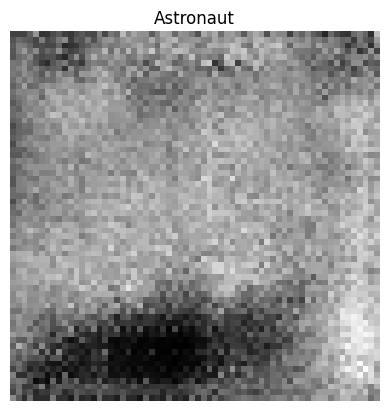

In [22]:
import torch`
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

nltk.download('punkt')

# Define hyperparameters
latent_dim = 128
base_feature_size = 128
num_channels = 1  # Grayscale images have 1 channel
learning_rate = 0.0001
beta1 = 0.5
num_epochs = 10 # Example number of epochs
batch_size = 128

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the Generator class
class Generator(nn.Module):
    def __init__(self, nz, nc, ngf):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

# Define the Discriminator class
class Discriminator(nn.Module):
    def __init__(self, nc, ndf):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

# Initialize models
netG = Generator(latent_dim, num_channels, base_feature_size).to(device)
netD = Discriminator(num_channels, base_feature_size).to(device)

# Loss function
criterion = nn.BCELoss()

# Optimizers
optimizerD = optim.Adam(netD.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=learning_rate, betas=(beta1, 0.999))

# Create a DataLoader for CIFAR-10 dataset
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(128),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataset = datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Training Loop
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        # Update Discriminator
        netD.zero_grad()
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        
        # Forward pass real batch through Discriminator
        output = netD(real_cpu)
        
        # Create labels for real data (1s) and make sure they match the size of the output
        label_real = torch.full(output.size(), 1., dtype=torch.float, device=device)
        errD_real = criterion(output, label_real)
        errD_real.backward()
        D_x = output.mean().item()

        # Generate fake images batch with Generator
        noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        fake = netG(noise)
        
        # Forward pass fake batch through Discriminator
        output = netD(fake.detach())
        
        # Create labels for fake data (0s) and make sure they match the size of the output
        label_fake = torch.full(output.size(), 0., dtype=torch.float, device=device)
        errD_fake = criterion(output, label_fake)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        
        # Combine the loss and update the Discriminator
        errD = errD_real + errD_fake
        optimizerD.step()

        # Update Generator
        netG.zero_grad()
        
        # Forward pass fake batch through Discriminator again
        output = netD(fake)
        
        # We want the generator to fool the discriminator, so labels are real (1s)
        label_fake.fill_(1.)
        errG = criterion(output, label_fake)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        if i % 50 == 0:
            print(f'[{epoch}/{num_epochs}][{i}/{len(dataloader)}] Loss_D: {errD.item()} Loss_G: {errG.item()} D(x): {D_x} D(G(z)): {D_G_z1} / {D_G_z2}')

# Define text_to_noise and generate_image functions
def text_to_noise(prompt, nz):
    tokens = word_tokenize(prompt)
    noise = torch.zeros(1, nz, 1, 1)
    for i, token in enumerate(tokens):
        noise[0, i % nz, 0, 0] = hash(token) % 1000 / 1000.0
    return noise

def generate_image(prompt, generator, nz):
    noise = text_to_noise(prompt, nz).to(device)
    with torch.no_grad():
        fake_image = generator(noise).detach().cpu()

    img = fake_image[0].permute(1, 2, 0).numpy()
    img = (img + 1) / 2
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(prompt)
    plt.show()

# User input
prompt = input("Enter a prompt: ")
generate_image(prompt, netG, latent_dim)


In [ ]:
nltk.download('punkt')

# Function to convert text to noise
def text_to_noise(prompt, nz):
    tokens = word_tokenize(prompt)
    noise = torch.zeros(1, nz, 1, 1)
    for i, token in enumerate(tokens):
        noise[0, i % nz, 0, 0] = hash(token) % 1000 / 1000.0
    return noise

# Function to generate image from text prompt
def generate_image(prompt, generator, nz, device):
    noise = text_to_noise(prompt, nz).to(device)
    with torch.no_grad():
        fake_image = generator(noise).detach().cpu()

    img = fake_image[0].permute(1, 2, 0).numpy()
    img = (img + 1) / 2
    plt.imshow(img)
    plt.axis('off')
    plt.title(prompt)
    plt.show()

# User input
prompt = input("Enter a prompt which you want to be generated ")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Adjusted hyperparameters
latent_dim = 100

# Assuming netG is already defined and loaded with trained weights
generate_image(prompt, netG, latent_dim, device)